## <font color=red>Closed Loop Adaptive Optics Using Pyramid Wavefront Sensor: Step by Step Guide</font>
----------------------------------------------------

### 1.  Create a telescope pupil grid: Visualize
### 2.   Create a telescope circular aperture: Visualize
### 3.   Create a telescope circular aperture grid: Visualize
### 4.   Create a pupil grid: visualize 
### 5. Create an Ideal plane wavefront: plot, visualize, etc. 
### 6.   Create an atmospheric layer phasescreen: plot, visualize, etc.
### 7.   Aberrate the wavefront: plot, visualize, etc.   
### 8.   Create a demagnifier to demagnify wavefront to the pupil grid
### 9.   Create a focal grid from the pupil grid.
### 10. Create a Fraunhofer Propagator from pupil grid to the focal grid 
### 11. Pass an ideal wavefront through demagnifier.
### 12. Propagate the demagnified ideal wavefront to the focal plane.
### 13. Note down the PSF and diffraction limited image
### 14. Pass an aberrated wavefront through demagnifier
### 15. Propagate the aberrated demagnified wavefront to the focal focal
### 16. Calculate the strehl ratio using diffraction limited image from step 13
### 17. Create a deformable mirror with _x_ number of actuators on the pupil grid
### 18. Create a (Pyramid) Wavefront sensor
### 19. Calibrate the deformable mirror using ideal wavefront and find out the interaction matrix/reconstruction matrix
### 20. We will also be creating Noiseless detector as a camera
### 21. Now we will start AO closed loop 
### 22. Pass(forward) aberrated wavefront through deformable mirror.
### 23a. Propagate the wavefront reflecting from DM to the focal grid.
### 23b. Pass(forward) wavefront reflecting from DM through the Wavefront sensor.
### 24. Note down image obtained at WFS from detector.
### 25. Note down the difference of obtained image from step 24 and reference image from step 13.
### 26. Apply correction to DM based on difference obtained in Step 25
### 27. Repeate Step 22-26 _t_ number of times
### 28. After _t_ times, record the final image at the focal plane (the result of 23a after _t_ steps).
### 29. Calculate PSF and Strehl ratio from image in Step 28.
### 30. Make inference about how much correction you did.

## Note: above method is for just one snapshot of aberrated wavefront received at DM.

![https://www.northropgrumman.com/BusinessVentures/SonomaPhotonics/IntelligentOptics/Technology/PublishingImages/aos_Schematic.jpg](https://www.northropgrumman.com/BusinessVentures/SonomaPhotonics/IntelligentOptics/Technology/PublishingImages/aos_Schematic.jpg)

# -----------------------------------------------------------------

In [1]:
import sys
sys.path.insert(1, '../../hcipy')
from hcipy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib as mpl

%matplotlib inline

# 1. Create a telescope pupil grid

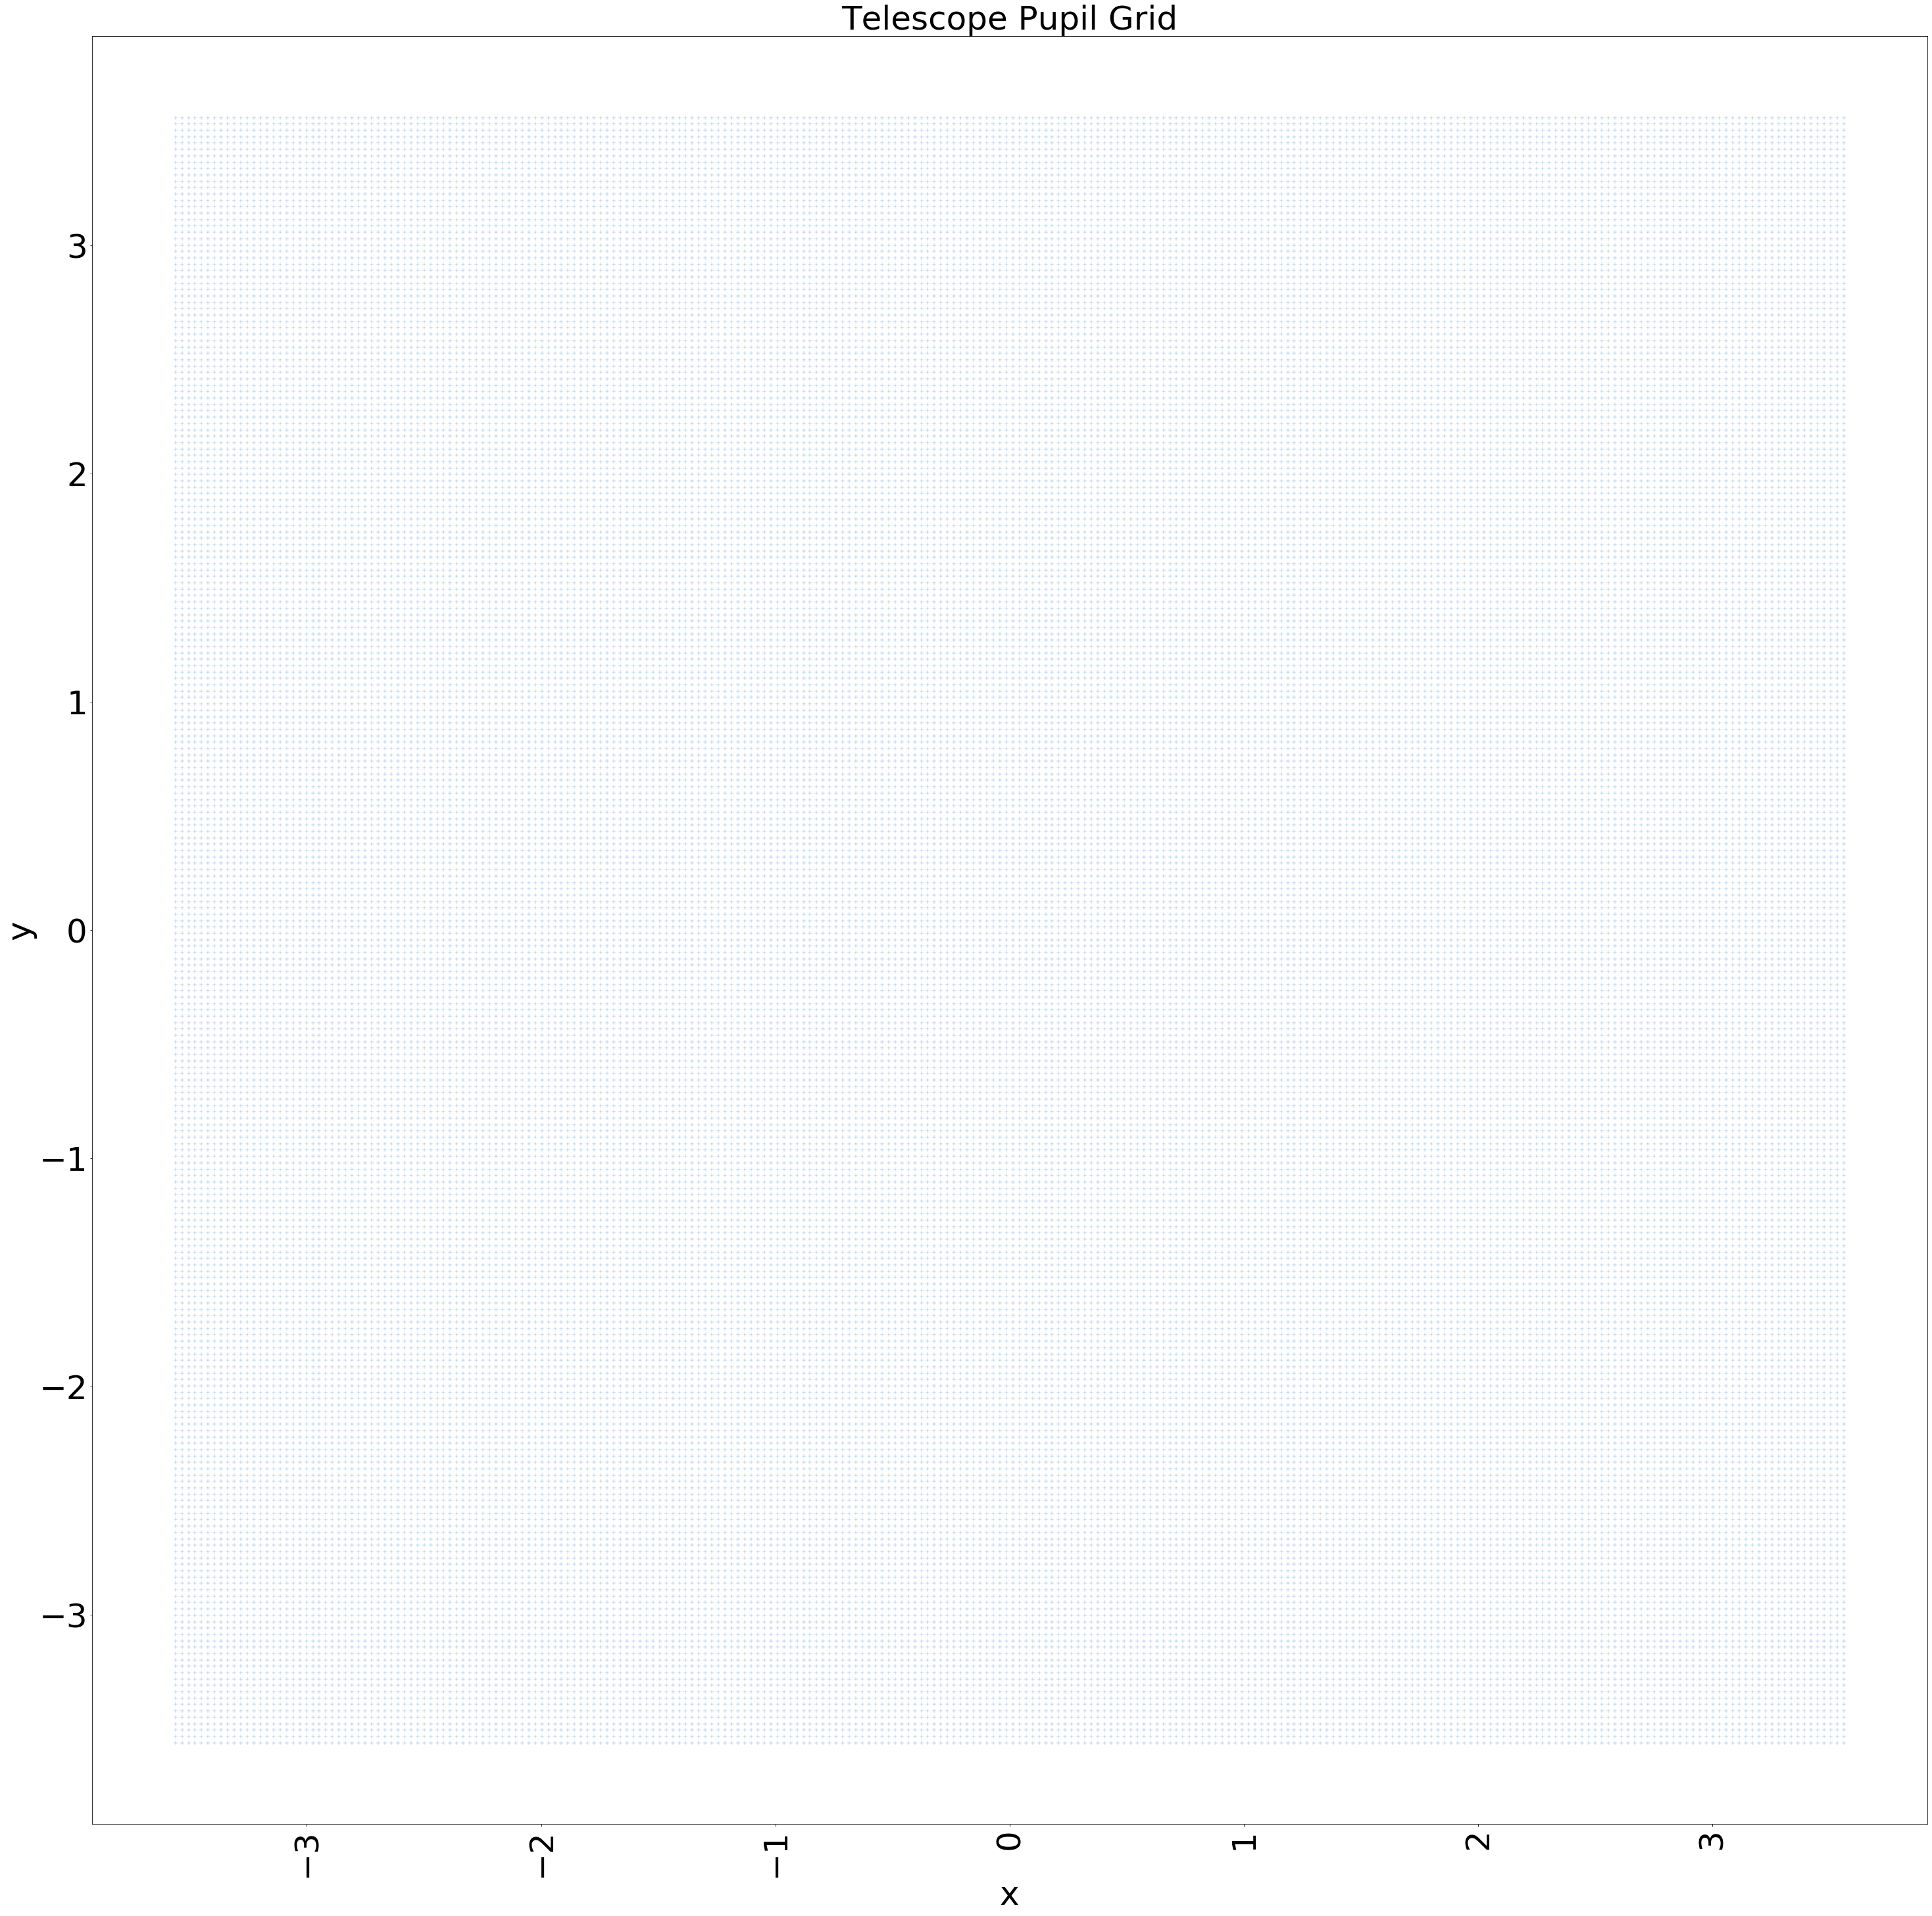

In [2]:
N = 256
wavelength = 842.0E-9 # 842 nm
telescope_diameter = 6.5 # 6.5 m
zero_magnitude_flux = 3.9E10
stellar_magnitude = 0

telescope_pupil_grid = make_pupil_grid(N, telescope_diameter*1.1) # Pupil grid is slightly bigger than aperture
# Visualize the grid
plt.figure(figsize=(50,50))
plt.plot(telescope_pupil_grid.x, telescope_pupil_grid.y, '+')
plt.title('Telescope Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

# 2. Create a telescope circular aperture
# 3. Create a telescope circular aperture grid

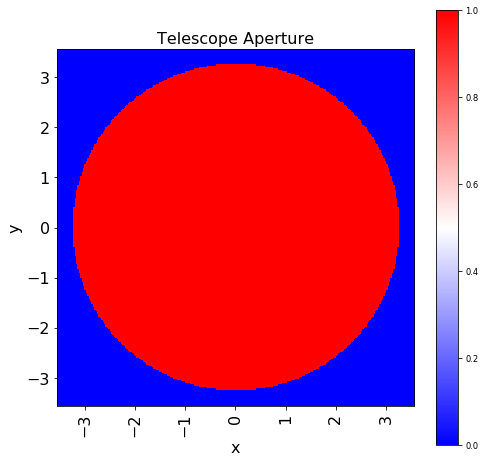

In [3]:
telescope_aperture = circular_aperture(telescope_diameter)
telescope_aperture_grid = telescope_aperture(telescope_pupil_grid)
plt.figure(figsize=(8,8))
imshow_field(telescope_aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Telescope Aperture', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

# 4. Create a pupil grid

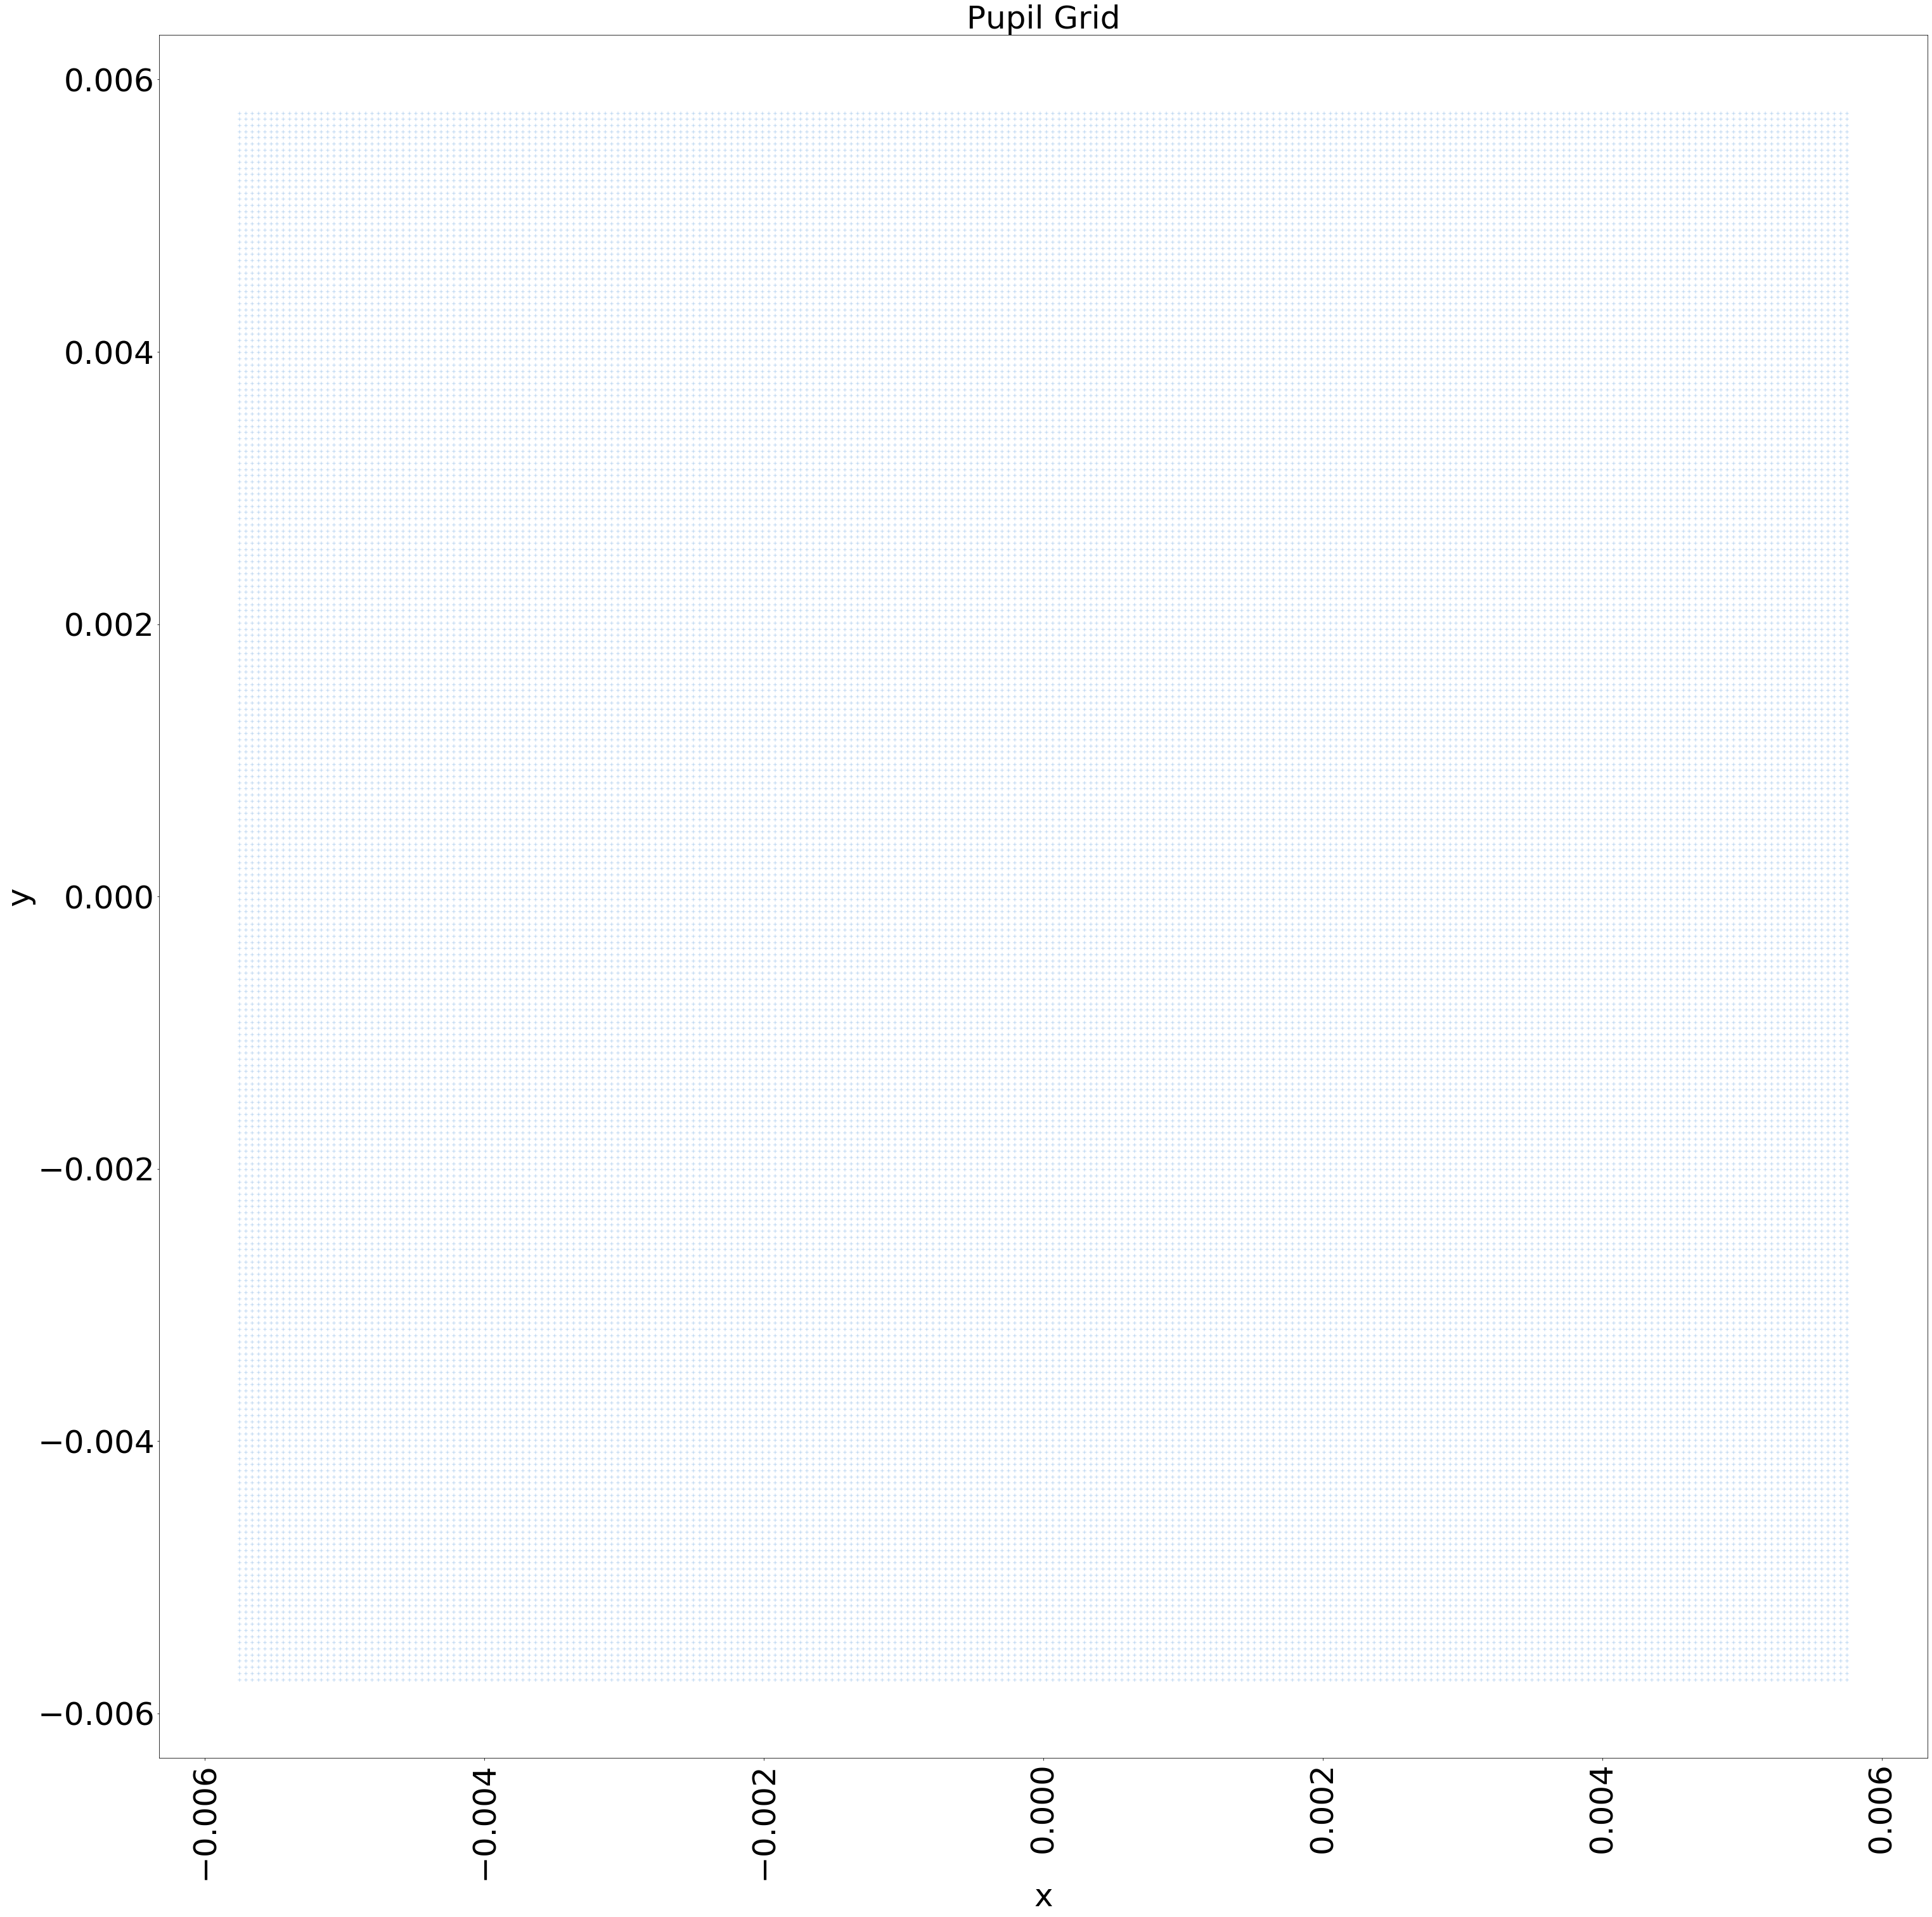

In [4]:
D = 10.5e-3 # 10.5mm
pupil_grid = make_pupil_grid(N, D*1.1)

## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(pupil_grid.x, pupil_grid.y, '+')
plt.title('Pupil Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)

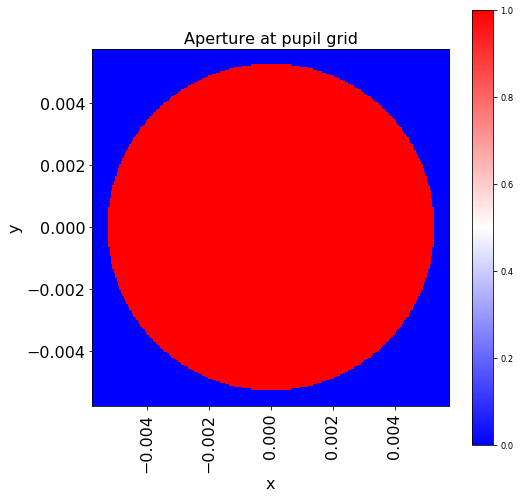

In [5]:
aperture = circular_aperture(D)

aperture_grid = aperture(pupil_grid)
plt.figure(figsize=(8,8))

imshow_field(aperture_grid, cmap = 'bwr')
plt.colorbar()
plt.title('Aperture at pupil grid', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

# 5. Create an Ideal plane wavefront

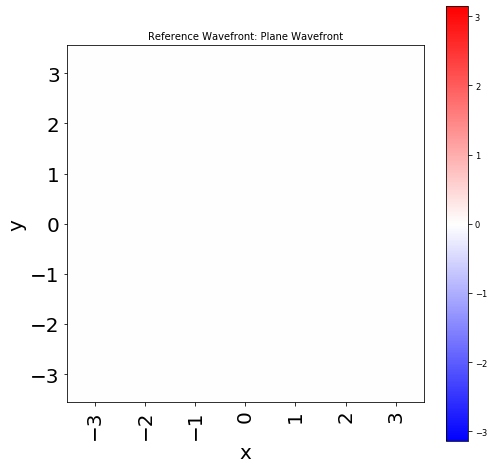

In [6]:
wf_ref = Wavefront(telescope_aperture_grid, wavelength)
wf_ref.total_power = 100000 # Photons per second
plt.figure(figsize=(8,8))
imshow_field(wf_ref.phase*telescope_aperture_grid, vmin=-np.pi, vmax=np.pi, cmap='bwr'); 
plt.title('Reference Wavefront: Plane Wavefront')
xfont = plt.xlabel('x', fontsize=20)
yfont = plt.ylabel('y', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
plt.colorbar()


# 6. Create an atmospheric layer phasescreen

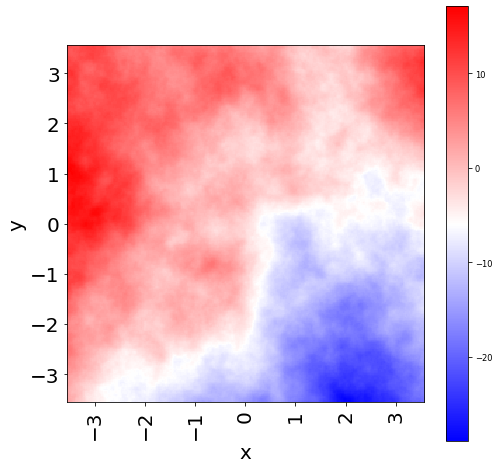

In [7]:
# Atmospheric parameters
pixels_per_frame = 1 # In this way, you can finely control how phasescreen moves across the aperture
velocity = np.array([pixels_per_frame, 0]) # 2 D Array with x and y component of the velocity
L0 = 40 # Outer Scale
r0 = 0.2 # Fried parameter
height = 0 # Create only one layer near the ground

# Now make the atmosphere
np.random.seed(23)
layers = []
layer = InfiniteAtmosphericLayer(telescope_pupil_grid, Cn_squared_from_fried_parameter(r0, 500e-9), L0, velocity*telescope_pupil_grid.delta[0], height, 2)
layers.append(layer)
atmosphere = MultiLayerAtmosphere(layers, False)
plt.figure(figsize=(8,8))
imshow_field(layer.phase_for(wavelength), cmap='bwr')
xfont = plt.xlabel('x', fontsize=20)
yfont = plt.ylabel('y', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
plt.colorbar()
plt.show()

# 7. Aberrate the wavefront through Atmosphere

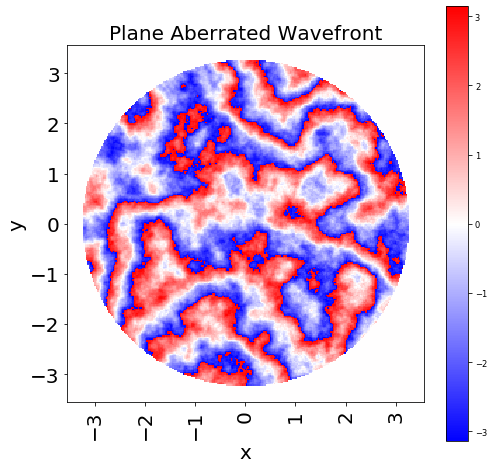

In [8]:
timestep = 100
atmosphere.evolve_until(timestep)
wf_tel_atmosphere = atmosphere.forward(wf_ref)
plt.figure(figsize=(8,8))
imshow_field(wf_tel_atmosphere.phase*telescope_aperture_grid, vmin=-np.pi, vmax=np.pi, cmap='bwr'); 
plt.title('Plane Aberrated Wavefront', fontsize=20)
xfont = plt.xlabel('x', fontsize=20)
yfont = plt.ylabel('y', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
plt.colorbar()


# 8. Create a demagnifier to demagnify wavefront to the pupil grid

In [9]:
mag = Magnifier(D/telescope_diameter) # Take the pupil down from telescope diameter to 10.5mm





# 9. Create a focal grid from the pupil grid.

/home/ivory/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This functions signature is deprecated and will be removed with the next major update. Use the updated function signature or call make_focal_grid_from_pupil_grid() directly instead.
  """Entry point for launching an IPython kernel.


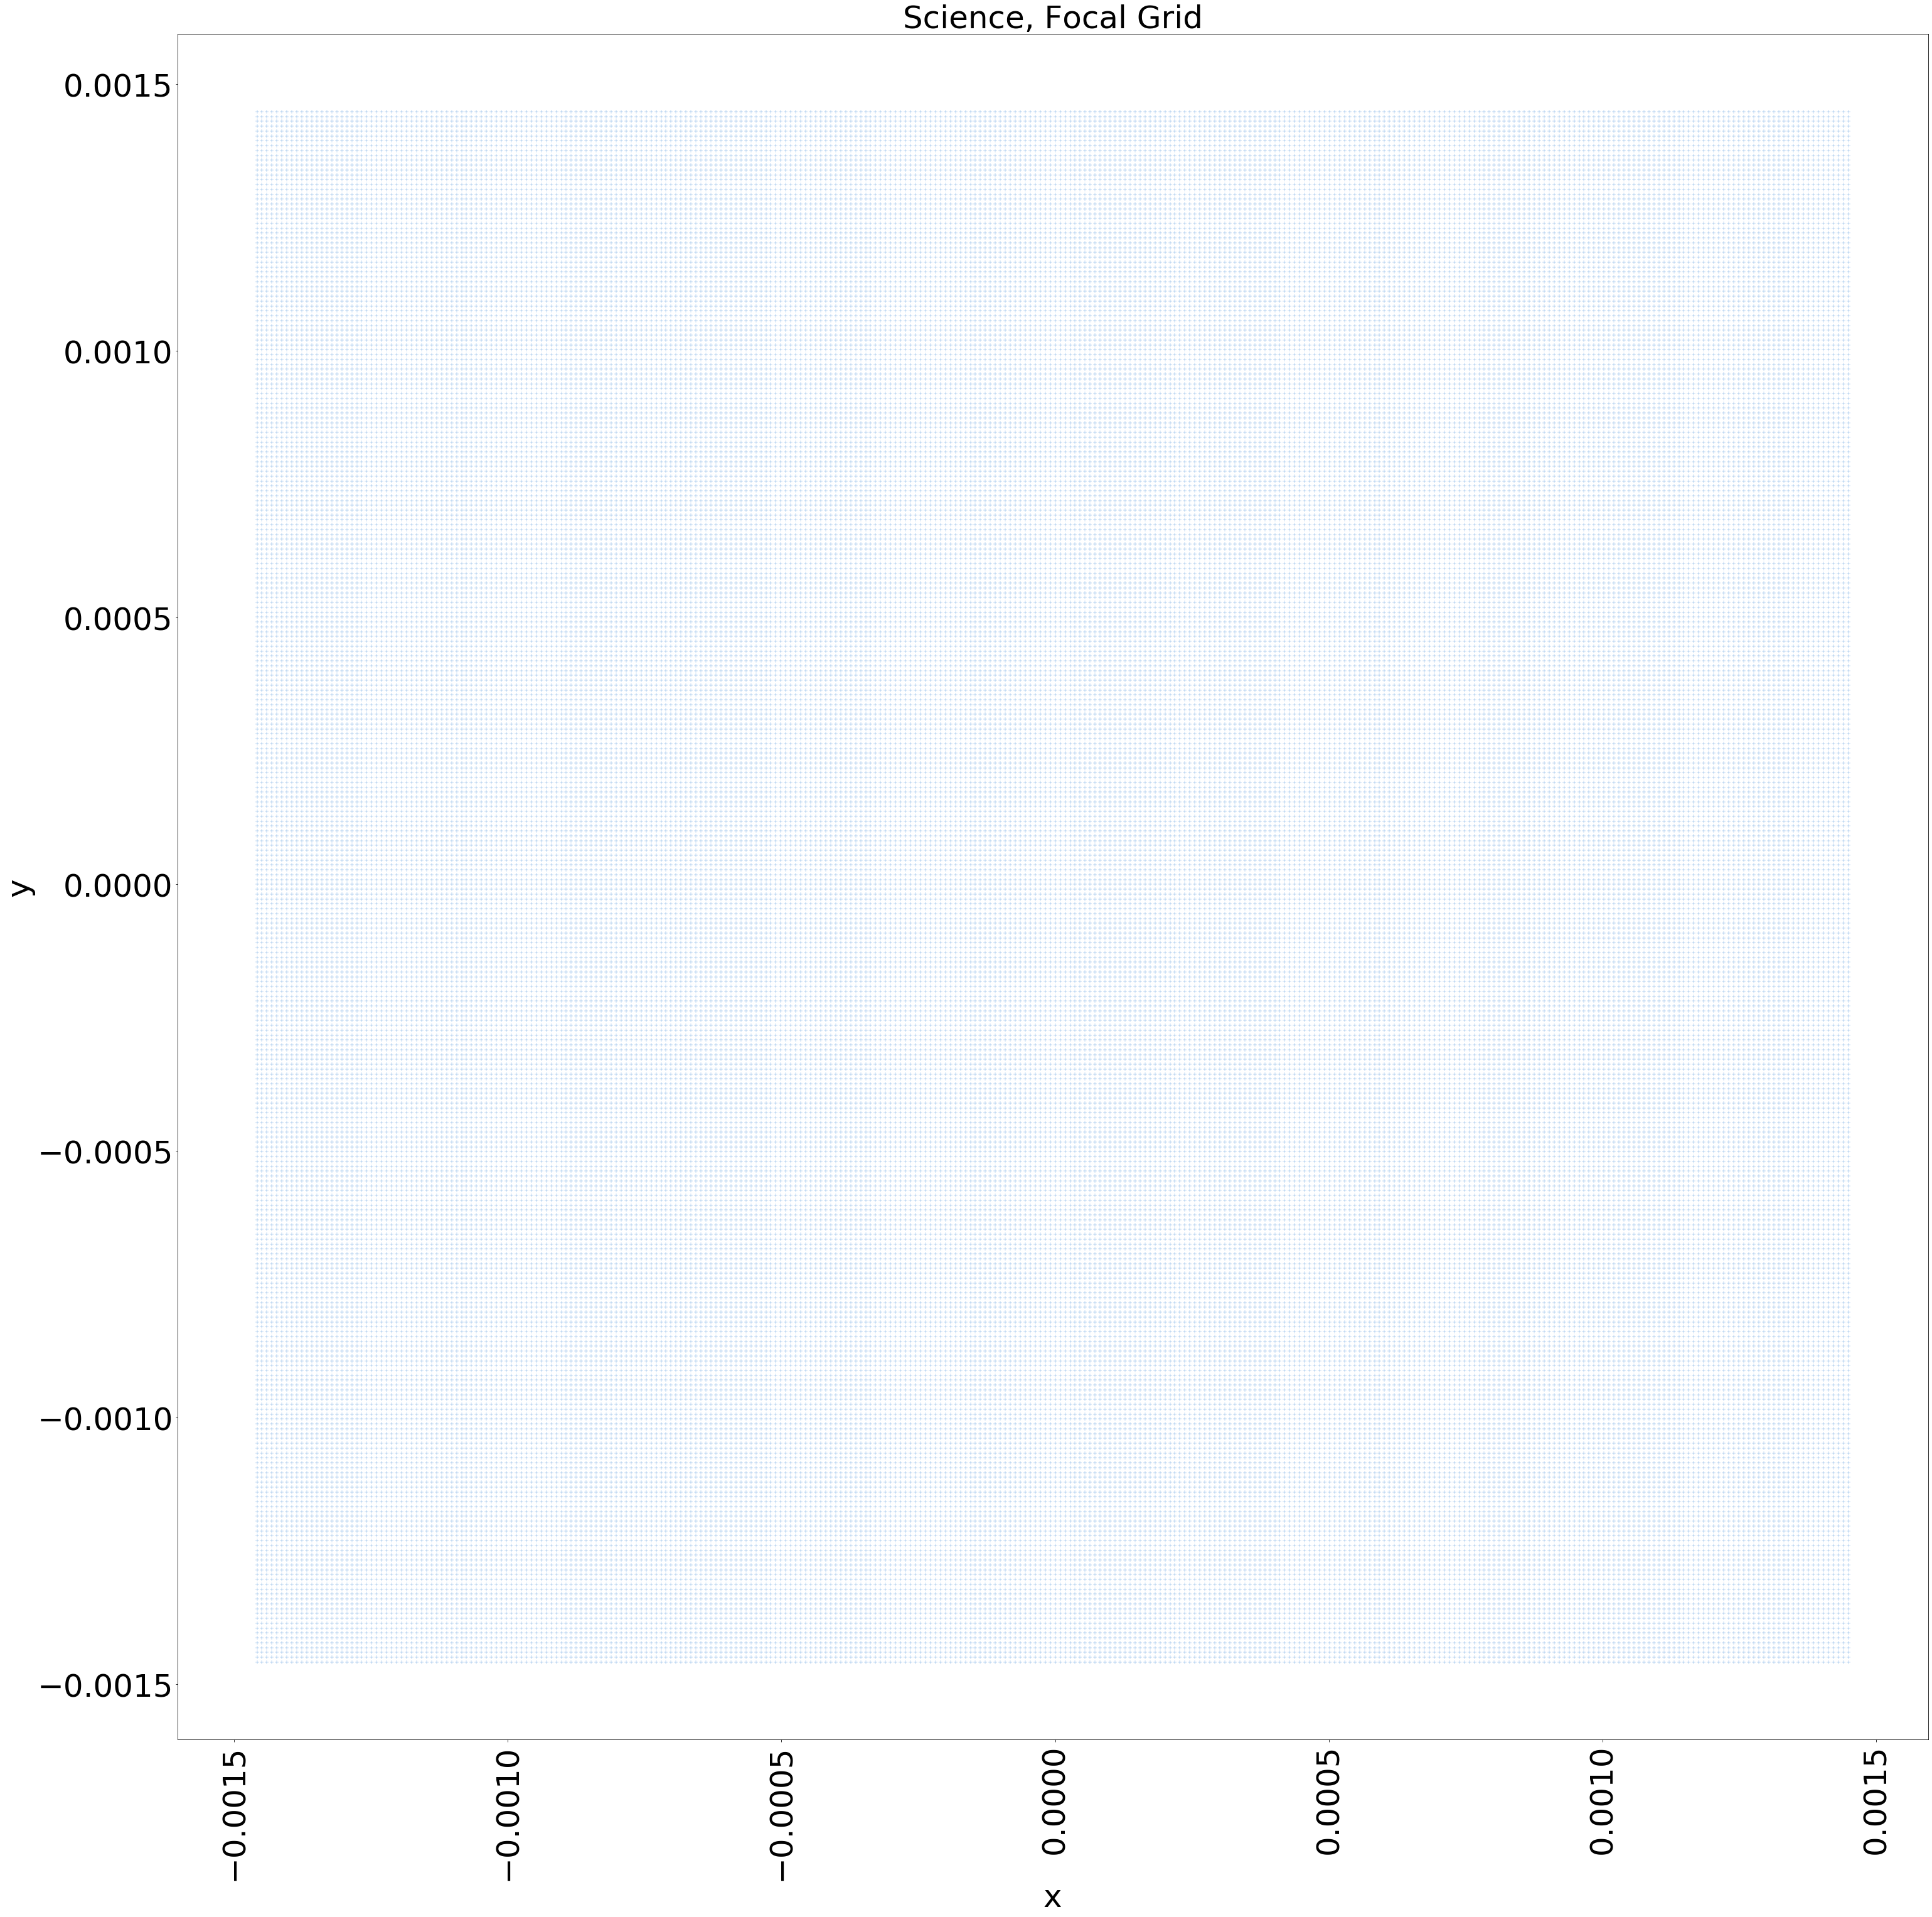

In [10]:
science_focal_grid = make_focal_grid(pupil_grid, 8, 20, wavelength)
## Just plotting something
plt.figure(figsize=(50,50))
plt.plot(science_focal_grid.x, science_focal_grid.y, '+')
plt.title('Science, Focal Grid',fontsize=50)
xfont = plt.xlabel('x', fontsize=50)
yfont = plt.ylabel('y', fontsize=50)
xticks = plt.xticks(fontsize=50, rotation=90)
yticks = plt.yticks(fontsize=50, rotation=0)


# 10. Create a Fraunhofer Propagator from pupil grid to the focal grid

In [11]:
propagator = FraunhoferPropagator(pupil_grid, science_focal_grid)
propagator

<hcipy.optics.optical_element.make_agnostic_optical_element.<locals>.decorator.<locals>.AgnosticOpticalElement at 0x7f2f9f2397b8>

# 11. Pass an ideal wavefront through demagnifier.

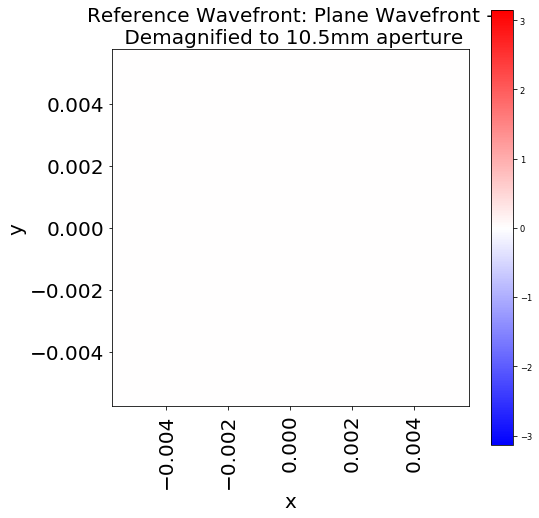

In [12]:
wf_ref_demagnified = mag.forward(wf_ref)
plt.figure(figsize=(8,8))
imshow_field(wf_ref_demagnified.phase*aperture_grid, vmin=-np.pi, vmax=np.pi, cmap='bwr'); 
plt.title('Reference Wavefront: Plane Wavefront -\n Demagnified to 10.5mm aperture',fontsize=20)
xfont = plt.xlabel('x', fontsize=20)
yfont = plt.ylabel('y', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
plt.colorbar()

# 12. Propagate the demagnified ideal wavefront to the focal plane.

In [13]:
wf_ref_demagnified_prop = propagator.forward(wf_ref_demagnified)
wf_ref_diff_lim_img = wf_ref_demagnified_prop.power # Diffraction Limited Image
Inorm = wf_ref_diff_lim_img.max()


# 14. Pass an aberrated wavefront through demagnifier¶

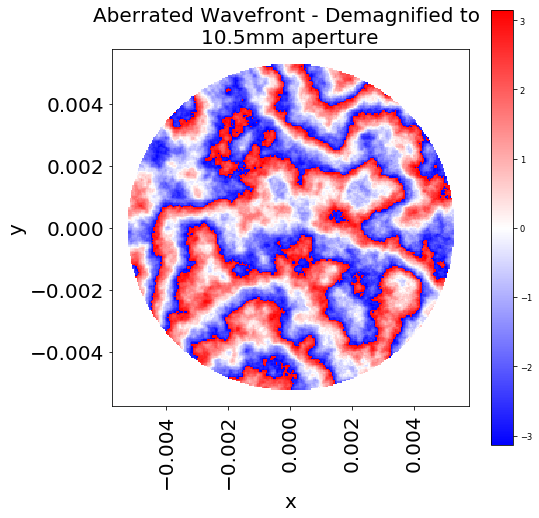

In [14]:
wf_atmosphere_demagnified = mag.forward(wf_tel_atmosphere)
plt.figure(figsize=(8,8))
imshow_field(wf_atmosphere_demagnified.phase*aperture_grid, vmin=-np.pi, vmax=np.pi, cmap='bwr'); 
plt.title('Aberrated Wavefront - Demagnified to \n10.5mm aperture',fontsize=20)
xfont = plt.xlabel('x', fontsize=20)
yfont = plt.ylabel('y', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
plt.colorbar()

# 15. Propagate the aberrated demagnified wavefront to the focal focal

In [15]:
wf_atmosphere_demagnified_prop = propagator.forward(wf_atmosphere_demagnified)
wf_atmoshphere_img = wf_atmosphere_demagnified_prop.power


# 16. Calculate the strehl ratio using diffraction limited image

In [16]:
strehl_ratio_aberrated = wf_atmoshphere_img[np.argmax(wf_ref_diff_lim_img)]/wf_atmoshphere_img.max()



In [17]:
strehl_ratio_aberrated

0.05748503372484844

# 17. Create a deformable mirror with _x_ number of actuators on the pupil grid

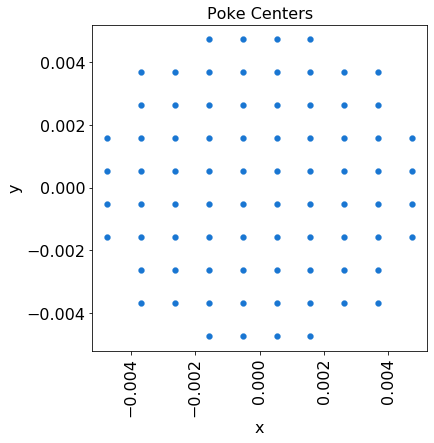

In [18]:
num_actuators = 10 # Number of actuators
pitch = D/num_actuators # Sigma Square
poke_centers = make_pupil_grid(num_actuators, D) # Aka Actuator Grids

poke_centers = poke_centers.subset(poke_centers.as_('polar').r < D/2)
## Just plotting something
plt.figure(figsize=(6,6))
plt.plot(poke_centers.x, poke_centers.y, 'o')
plt.title('Poke Centers',fontsize=16)
xfont = plt.xlabel('x', fontsize=16)
yfont = plt.ylabel('y', fontsize=16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)

Num of modes = 80


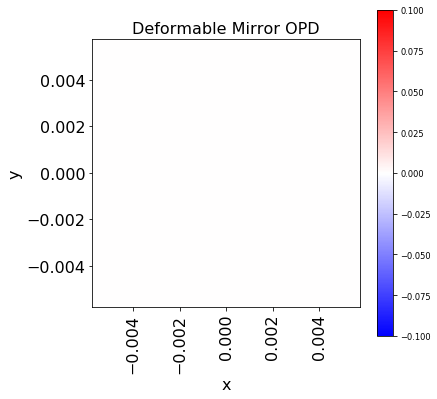

In [19]:
dm_modes = make_gaussian_pokes(pupil_grid, poke_centers, pitch*np.sqrt(2)) #modes in gaussian basis
num_modes = poke_centers.x.size
print('Num of modes = {:g}'.format(num_modes))
deformable_mirror = DeformableMirror(dm_modes)
deformable_mirror.actuators = np.zeros(num_modes)

plt.figure(figsize=(6,6))

imshow_field(deformable_mirror.opd, cmap = 'bwr')
plt.colorbar()
plt.title('Deformable Mirror OPD', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()

# 18. Create a (Pyramid) Wavefront sensor

In [20]:
pwfs = PyramidWavefrontSensorOptics(pupil_grid, wavelength_0=wavelength)

# 20.  We will also be creating Noiseless detector as a camera

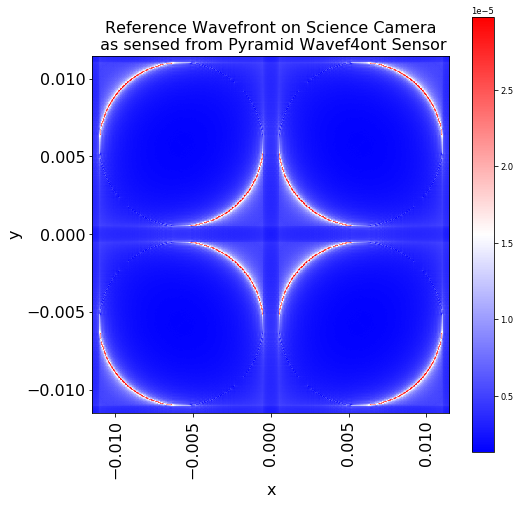

In [21]:
science_camera = NoiselessDetector()


# get the reference image
wf_ref_demagnified_pwfs = pwfs.forward(wf_ref_demagnified)
science_camera.integrate(wf_ref_demagnified_pwfs, 1)
image_ref = science_camera.read_out()

image_ref /= image_ref.sum() # Normalizing


plt.figure(figsize=(8,8))
imshow_field(image_ref, cmap = 'bwr')
plt.colorbar()
plt.title('Reference Wavefront on Science Camera\n as sensed from Pyramid Wavef4ont Sensor', fontsize=16)
plt.xlabel('x', fontsize = 16)
plt.ylabel('y', fontsize = 16)
xticks = plt.xticks(fontsize=16, rotation=90)
yticks = plt.yticks(fontsize=16, rotation=0)
plt.show()


# 19. Calibrate the deformable mirror using ideal wavefront and find out the interaction matrix/reconstruction matrix

In [22]:
# Create the information matrix
probe_amplitude = 0.01*wavelength
slopes = []

for ind in range(num_modes):
    if (ind+1)%10 == 0:
        print("Mesasure response to mode {:d}/{:d}\n".format(ind+1, num_modes))
    slope = 0
    
    for s in [-1, 1]:
        amplitude = np.zeros((num_modes, ))
        amplitude[ind] = s*probe_amplitude
        
        deformable_mirror.actuators = amplitude
        
        dm_wf = deformable_mirror.forward(wf_ref_demagnified)
        wfs_wf = pwfs.forward(dm_wf)
        
        science_camera.integrate(wfs_wf, 1)
        image = science_camera.read_out()
        image /= np.sum(image) # Normalizing
        
        slope += s*(image - image_ref)/(2*probe_amplitude)
        
    slopes.append(slope)
slopes = ModeBasis(slopes)


Mesasure response to mode 10/80

Mesasure response to mode 20/80

Mesasure response to mode 30/80

Mesasure response to mode 40/80

Mesasure response to mode 50/80

Mesasure response to mode 60/80

Mesasure response to mode 70/80

Mesasure response to mode 80/80



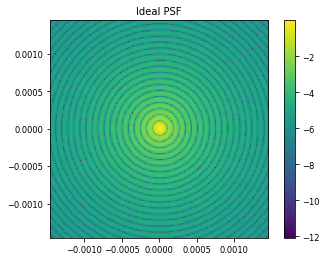

In [23]:
PSF_ideal = propagator.forward(deformable_mirror.forward(wf_ref_demagnified)).power/Inorm
imshow_field(np.log10(PSF_ideal))
plt.title('Ideal PSF')
plt.colorbar()

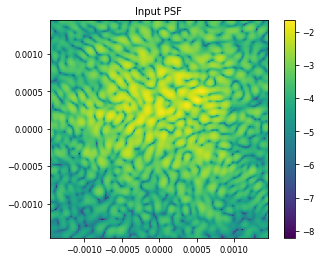

In [24]:
PSF_in = propagator.forward(deformable_mirror.forward(wf_atmosphere_demagnified)).power/Inorm
imshow_field(np.log10(PSF_in))
plt.title('Input PSF')
plt.colorbar()

In [25]:
rcond = 1E-3
reconstruction_matrix = inverse_tikhonov(slopes.transformation_matrix, rcond=rcond, svd = None)

In [26]:
AO_Frequency = 1000
delta_t = 1.0/AO_Frequency
leakage = 0.0
gain = 0.5
wf_atmoshphere_img = wf_atmosphere_demagnified_prop.power # Diffraction Limited Image

In [27]:

'''

21. Now we will start AO closed loop
22. Pass(forward) aberrated wavefront through deformable mirror.
23a. Propagate the wavefront reflecting from DM to the focal grid.
23b. Pass(forward) wavefront reflecting from DM through the Wavefront sensor.
24. Note down image obtained at WFS from detector.
25. Note down the difference of obtained image from step 24 and reference image from step 13.
26. Apply correction to DM based on difference obtained in Step 25
27. Repeate Step 22-26 t number of times
28. After t times, record the final image at the focal plane (the result of 23a after t steps).
29. Calculate PSF and Strehl ratio from image in Step 28.
30. Make inference about how much correction you did.


'''
wf_dm_aberrated_modified  = deformable_mirror.forward(wf_atmosphere_demagnified)
final_wf = propagator.forward(wf_dm_aberrated_modified)
final_wf_img = final_wf.power # Diffraction Limited Image

strehl_ratio_corrected = final_wf_img[np.argmax(wf_ref_diff_lim_img)]/final_wf_img.max()
print('strehl_ratio_corrected',strehl_ratio_corrected)


deformable_mirror.actuators = np.zeros(deformable_mirror.actuators.shape)
actuators = []
max_strehl_index = -1.0
max_strehl = 0.0
strehl_ratio = []
for i in range(200):
    wf_dm_aberrated  = deformable_mirror.forward(wf_atmosphere_demagnified) #22
    wf_pyramid = pwfs.forward(wf_dm_aberrated)

    science_camera.integrate(wf_pyramid, 1)
    wfs_image = large_poisson(science_camera.read_out()).astype(np.float)
    wfs_image /= np.sum(wfs_image)

    diff_image = image_ref - wfs_image
    deformable_mirror.actuators = (1 - leakage)*deformable_mirror.actuators - gain*reconstruction_matrix.dot(diff_image)
    actuators.append(deformable_mirror.actuators)

    

    wf_dm_aberrated_modified  = deformable_mirror.forward(wf_atmosphere_demagnified)
    final_wf = propagator.forward(wf_dm_aberrated_modified)
    final_wf_img = final_wf.power # Diffraction Limited Image

    strehl_ratio_corrected = final_wf_img[np.argmax(wf_ref_diff_lim_img)]/final_wf_img.max()
    strehl_ratio.append(strehl_ratio_corrected)
    
    if strehl_ratio_corrected > max_strehl:
        max_strehl = strehl_ratio_corrected
        max_strehl_index = i
    
    
    print('strehl_ratio_corrected',strehl_ratio_corrected)
    

print("maximum strehl ratio is ", max_strehl)

deformable_mirror.actuators = actuators[max_strehl_index]

wf_dm_aberrated_modified  = deformable_mirror.forward(wf_atmosphere_demagnified)
final_wf = propagator.forward(wf_dm_aberrated_modified)
final_wf_img = final_wf.power # Diffraction Limited Image


strehl_ratio_corrected 0.056142940537110345
strehl_ratio_corrected 0.029029794335721452
strehl_ratio_corrected 0.012792572216296861
strehl_ratio_corrected 0.005017804883654208
strehl_ratio_corrected 0.004162319912836459
strehl_ratio_corrected 0.004076673569267008
strehl_ratio_corrected 0.0026783640656047997
strehl_ratio_corrected 0.0019054553675356717
strehl_ratio_corrected 0.004788230086675815
strehl_ratio_corrected 0.0022771712064945334
strehl_ratio_corrected 0.005534369641173473
strehl_ratio_corrected 0.024121181058318064
strehl_ratio_corrected 0.017814647296576443
strehl_ratio_corrected 0.012981160088139257
strehl_ratio_corrected 0.10056300792212026
strehl_ratio_corrected 0.21967937421799644
strehl_ratio_corrected 0.270424317658714
strehl_ratio_corrected 0.2720232997350259
strehl_ratio_corrected 0.08281366576537649
strehl_ratio_corrected 0.005783237578138997
strehl_ratio_corrected 0.07150733418415191
strehl_ratio_corrected 0.0979890249511194
strehl_ratio_corrected 0.103370808650312

strehl_ratio_corrected 0.11724146656808472
strehl_ratio_corrected 0.13422032699805325
strehl_ratio_corrected 0.16153818859153773
strehl_ratio_corrected 0.18102861110115184
strehl_ratio_corrected 0.17143054191590684
strehl_ratio_corrected 0.16313878183671507
strehl_ratio_corrected 0.15302358419150955
strehl_ratio_corrected 0.14826373915428165
strehl_ratio_corrected 0.14024536150062364
strehl_ratio_corrected 0.12878695684874528
strehl_ratio_corrected 0.11802074729868184
maximum strehl ratio is  0.3387955976070172


In [28]:
strehl_ratio_aberrated


0.05748503372484844

In [29]:
strehl_ratio_corrected

0.11802074729868184

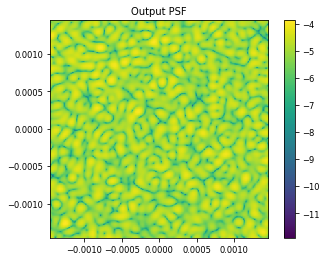

In [30]:
PSF_out = final_wf_img/Inorm
imshow_field(np.log10(PSF_out))
plt.title('Output PSF')
plt.colorbar()

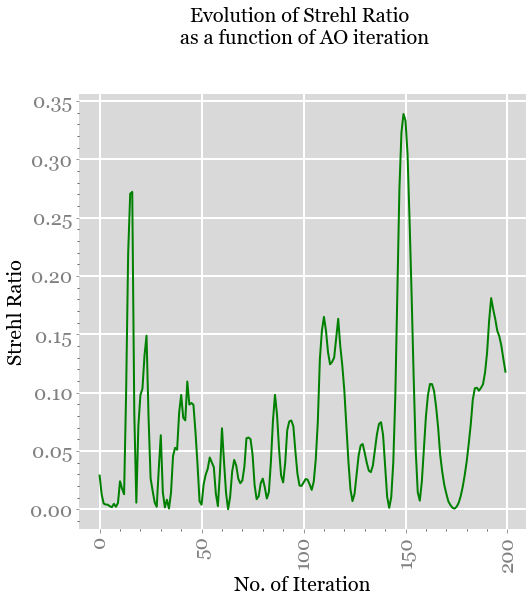

In [31]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams["figure.figsize"] = [8, 8]
mpl.rcParams['lines.color'] = 'r'
mpl.rcParams['font.family'] = "Georgia"
mpl.rcParams['font.size'] = 24
fig, ax = plt.subplots()
fig.figsize = [12, 12]
plt.plot(strehl_ratio, linewidth='2.0', color='green')
ax.set_axisbelow(True)
ax.minorticks_on()
ax.set_facecolor((0.85, 0.85, 0.85))
axis = plt.gca()
ax.grid(which='major', linestyle='-', linewidth='2.0', color='white')
# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)
# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')
    
    
#ax.grid(which='minor', linestyle=':', linewidth='0.25', color='black')
plt.title('Evolution of Strehl Ratio \n as a function of AO iteration\n\n',fontsize=20)

xfont = plt.xlabel('No. of Iteration', fontsize=20)
yfont = plt.ylabel('Strehl Ratio', fontsize=20)
xticks = plt.xticks(fontsize=20, rotation=90)
yticks = plt.yticks(fontsize=20, rotation=0)
